<a href="https://colab.research.google.com/github/Jaksta1/Uczenie_Maszynowe_2025/blob/main/Jakub_Kownacki_Praca_domowa_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------
# 1. Importowanie bibliotek
-----------------------------------------------------------

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Konfiguracja urządzenia (GPU jeśli dostępne, inaczej CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---------------------------------------------------
#2.Pobranie zbioru danych MNIST i zdefiniowanie sieci
---------------------------------------------------

In [2]:
# Definicja transformacji i wczytanie zbioru danych MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # konwersja obrazu na tensor
    transforms.Normalize((0.1307,), (0.3081,))  # normalizacja danych (średnia, odchylenie)
])

# Załadowanie zbioru treningowego MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2048, shuffle=True)  # loader z batchami

# Załadowanie zbioru testowego MNIST
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Definicja sieci MLP (Multi-Layer Perceptron)
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()  # warstwa spłaszczająca (28x28 => 784)
        # Warstwa 1: wejście 784 -> 1024 neurony
        self.linear1 = nn.Linear(28*28, 1024)
        self.relu1 = nn.ReLU()
        # Warstwa 2: 1024 -> 2048
        self.linear2 = nn.Linear(1024, 2048)
        self.relu2 = nn.ReLU()
        # Warstwa 3: 2048 -> 256
        self.linear3 = nn.Linear(2048, 256)
        self.relu3 = nn.ReLU()
        # Warstwa wyjściowa: 256 -> 10 (klasy 0–9)
        self.linear4 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.05)  # dropout z prawdopodobieństwem 5%

    def forward(self, x):  # x: B x 1 x 28 x 28
        x = self.flatten(x)  # spłaszczenie: B x 784
        x = self.linear1(x)  # warstwa liniowa 1
        x = self.relu1(x)    # aktywacja ReLU 1
        x = self.linear2(x)  # warstwa liniowa 2
        x = self.relu2(x)    # aktywacja ReLU 2
        x = self.linear3(x)  # warstwa liniowa 3
        x = self.relu3(x)    # aktywacja ReLU 3
        x = self.linear4(x)  # warstwa wyjściowa
        x = self.dropout(x)  # dropout
        return x  # zwraca nieliniowe predykcje dla 10 klas

100%|██████████| 9.91M/9.91M [00:00<00:00, 138MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 30.2MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 93.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.22MB/s]


-----------------------------------------------------
#4. Trening sieci i test dokładności
-----------------------------------------------------

In [3]:
# Utworzenie instancji sieci i rozpoczęcie treningu
net = MLP().to(device)  # przeniesienie modelu na GPU lub CPU
optimizer = optim.Adam(net.parameters(), lr=0.001)  # optymalizator Adam z lr=0.001
criterion = nn.CrossEntropyLoss()  # funkcja straty: entropia krzyżowa

net.train()  # tryb treningowy
for epoch in range(5):  # uczymy przez 5 epok
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)  # przeniesienie danych na urządzenie
        optimizer.zero_grad()  # wyzerowanie gradientów
        outputs = net(inputs)  # przejście w przód przez sieć
        loss = criterion(outputs, labels)  # obliczenie straty
        loss.backward()  # propagacja wsteczna
        optimizer.step()  # aktualizacja wag
        if batch_idx % 5 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}")  # wypisanie straty co 5 batchy

# Ocena dokładności modelu na zbiorze testowym
def evaluate(model, loader):
    model.eval()  # tryb ewaluacyjny (bez dropoutu itp.)
    correct = 0
    total = 0
    with torch.no_grad():  # wyłączenie śledzenia gradientów
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # predykcja
            pred = outputs.argmax(dim=1)  # wybór klasy z najwyższym wynikiem
            correct += (pred == labels).sum().item()  # liczba poprawnych
            total += labels.size(0)  # łączna liczba próbek
    return correct / total  # dokładność jako ułamek

acc = evaluate(net, testloader)  # oblicz dokładność na zbiorze testowym
print(f"Test accuracy: {acc*100:.2f}%")  # wypisz wynik w %


Epoch 0, Batch 0, Loss: 2.3001
Epoch 0, Batch 5, Loss: 1.2113
Epoch 0, Batch 10, Loss: 0.7604
Epoch 0, Batch 15, Loss: 0.5610
Epoch 0, Batch 20, Loss: 0.4250
Epoch 0, Batch 25, Loss: 0.3305
Epoch 1, Batch 0, Loss: 0.2515
Epoch 1, Batch 5, Loss: 0.2608
Epoch 1, Batch 10, Loss: 0.2397
Epoch 1, Batch 15, Loss: 0.2425
Epoch 1, Batch 20, Loss: 0.2155
Epoch 1, Batch 25, Loss: 0.1799
Epoch 2, Batch 0, Loss: 0.1662
Epoch 2, Batch 5, Loss: 0.1469
Epoch 2, Batch 10, Loss: 0.1604
Epoch 2, Batch 15, Loss: 0.1376
Epoch 2, Batch 20, Loss: 0.1370
Epoch 2, Batch 25, Loss: 0.1235
Epoch 3, Batch 0, Loss: 0.1001
Epoch 3, Batch 5, Loss: 0.1129
Epoch 3, Batch 10, Loss: 0.0968
Epoch 3, Batch 15, Loss: 0.0921
Epoch 3, Batch 20, Loss: 0.1139
Epoch 3, Batch 25, Loss: 0.0998
Epoch 4, Batch 0, Loss: 0.0831
Epoch 4, Batch 5, Loss: 0.0721
Epoch 4, Batch 10, Loss: 0.0813
Epoch 4, Batch 15, Loss: 0.0764
Epoch 4, Batch 20, Loss: 0.0748
Epoch 4, Batch 25, Loss: 0.0704
Test accuracy: 97.92%


----------------------------------
#5. Mrozimy wagi sieci
----------------------------------

In [4]:
for param in net.parameters():
    param.requires_grad = False

--------------------------------------------------
#Zadanie 1: generowanie obrazów klasyfikowanych jako cyfry z szumu
--------------------------------------------------

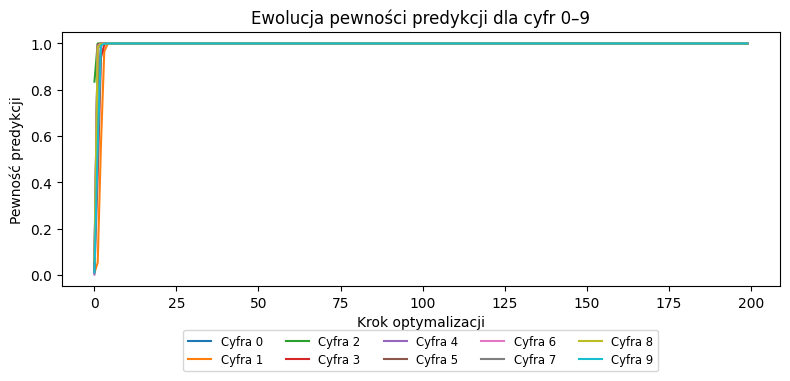

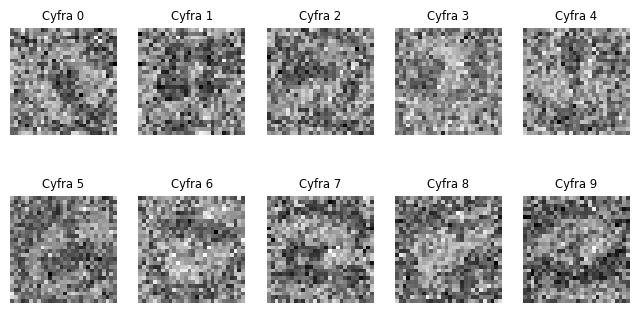

In [5]:
num_classes = 10
dream_input = torch.randn((num_classes, 1, 28, 28), device=device, requires_grad=True)  # losowe obrazy jako wejście
target = torch.arange(num_classes, device=device)  # etykiety docelowe: 0 do 9
optimizer_dream = optim.Adam([dream_input], lr=0.2)  # optymalizator dla wejścia

# Zbieranie snapshotów co 20 kroków
snapshots = []
conf_history = []  # historia pewności klasyfikacji

for step in range(200):
    optimizer_dream.zero_grad()
    outputs = net(dream_input)  # przejście przez sieć
    loss = criterion(outputs, target)  # strata CE: czy obraz wygląda jak docelowa cyfra
    loss.backward()
    optimizer_dream.step()

    # Obliczanie pewności przypisania klasy docelowej
    conf = torch.softmax(outputs, dim=1)[torch.arange(num_classes), target]
    conf_history.append(conf.cpu().detach().numpy())

    # Zapisywanie obrazu co 20 kroków
    if step % 20 == 0:
        snapshots.append(dream_input.detach().cpu().clone())


# Wyświetlenie wykresu pewności klasyfikacji
conf_array = np.array(conf_history)

plt.figure(figsize=(8,4))
for i in range(num_classes):
    plt.plot(conf_array[:, i], label=f"Cyfra {i}")  # pewność dla cyfry i w kolejnych iteracjach

plt.xlabel("Krok optymalizacji")
plt.ylabel("Pewność predykcji")
plt.title("Ewolucja pewności predykcji dla cyfr 0–9")
plt.legend(ncol=5, fontsize='small', bbox_to_anchor=(0.5, -0.15), loc="upper center")
plt.tight_layout()
plt.show()

# Przygotowanie figury do animacji
fig, axes = plt.subplots(2, 5, figsize=(8,4))  # siatka 2x5
imgs = []
for ax in axes.flatten():
    im = ax.imshow(np.zeros((28,28)), cmap='gray', animated=True, vmin=0, vmax=1)  # inicjalizacja pustych obrazków
    ax.axis('off')
    imgs.append(im)
# Dodaj tytuły kolumn (cyfry 0–9) tylko raz na górze
for j in range(0,5):
    axes[0, j].set_title(f"Cyfra {j}", fontsize='small', pad=6)
for j in range(5,10):
    axes[1, j-5].set_title(f"Cyfra {j}", fontsize='small', pad=6)
# Inicjalizacja klatek
def init():
    for im in imgs:
        im.set_array(np.zeros((28,28)))
    return imgs

# Funkcja animująca: aktualizuje wszystkie 10 obrazów w każdej ramce
def animate(frame_idx):
    batch = snapshots[frame_idx].squeeze(1).cpu().numpy()  # (10,28,28)
    for i, im in enumerate(imgs):
        img = batch[i]
        # Normalizacja obrazu do zakresu [0,1] – poprawa widoczności
        img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
        im.set_array(img_norm)
    return imgs

# Utworzenie animacji z zebranych klatek
anim = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(snapshots), interval=200, blit=True
)

# Wyświetlenie animacji w notebooku
HTML(anim.to_jshtml())

##KOMENTARZ DO ZADANIA 1

##**Czy wygenerowane obrazy przypominają rzeczywiste cyfry MNIST?**
Z przedstawionych wyników wyraźnie widać, że obrazy nie przypominają czytelnych znaków z MNIST. Zamiast tego są to rozmyte, zaszumione wzory z fragmentarycznymi kształtami.
##**Dlaczego tak się dzieje?**
**Brak priorytetu zgodności ze stylem danych:**\
Używając wyłącznie funkcji straty $ \mathrm{CrossEntropyLoss} $ bez dodatkowego terminu rekonstrukcji, optymalizacja zmierza do tego, aby sieć maksymalizowała pewność klasyfikacji, a nie zachowywała styl MNIST.\
**Gradientowe artefakty:**\
Maksymalizacja pewności prowadzi do wysokoczęstotliwościowych wzorów (pikselowy „szum”), które aktywują wewnętrzne reprezentacje klasy w sieci neuronowej, ale nie tworzą gładkich konturów.\
**Brak ograniczeń na dystrybucję pikseli:**\
Bez kar takich jak kara L2 piksele mogą przyjmować dowolne wartości, co skutkuje chaosem zamiast uporządkowanego kształtu.\
**Szybkie plateau optymalizacji:**\
Już po około 40 iteracjach optymalizacji zmiany stają się praktycznie niewidoczne – gradienty niemal zanikają, a wygenerowane obrazy przestają ewoluować. Dzieje się tak, ponieważ funkcja straty CrossEntropy szybko spada do wartości, przy której sieć ma bardzo wysoką pewność swoich predykcji. Na wykresie „Ewolucji pewności predykcji” widać, że współczynniki pewności niemal natychmiast stabilizują się blisko 1, więc dalsze modyfikacje obrazów przynoszą znikomy spadek straty, a gradienty stają się zbyt małe, by dokonać znaczących zmian.

------------------------------------------------------------
#Zadanie 2: Wygenerowanie obrazu podobnego do dwóch liczb równocześnie (1 i 7)
-------------------------------------------------------------

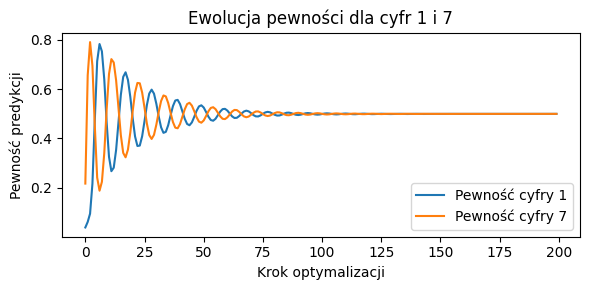

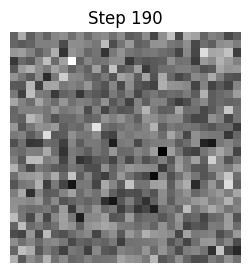

In [6]:
pair_input = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)  # pojedynczy losowy obraz
pair_target = [1, 7]  # docelowe cyfry
optimizer_pair = optim.Adam([pair_input], lr=0.05)  # optymalizator dla wejścia

# Zbieranie snapshotów co 10 kroków
snapshots = []
conf_history = []  # lista wektorów pewności dla cyfr [1,7]

for step in range(200):
    optimizer_pair.zero_grad()
    # duplikujemy wejście, by stworzyć dwie kopie i obliczyć dwie straty
    outputs = net(pair_input.expand(2, -1, -1, -1))  # batch rozmiaru 2
    loss1 = criterion(outputs[0:1], torch.tensor([1], device=device))  # strata dla cyfry 1
    loss2 = criterion(outputs[1:2], torch.tensor([7], device=device))  # strata dla cyfry 7
    loss = loss1 + loss2  # łączna strata
    loss.backward()
    optimizer_pair.step()

    # Obliczanie pewności predykcji dla obu docelowych cyfr
    probs = torch.softmax(outputs, dim=1)
    conf1 = probs[0, 1].item()  # pewność dla cyfry '1'
    conf7 = probs[1, 7].item()  # pewność dla cyfry '7'
    conf_history.append((conf1, conf7))
    if step % 10 == 0:
        snapshots.append(pair_input.detach().cpu().clone())  # zapis snapshotu

# --- wykres ewolucji pewności predykcji ---
conf_array = np.array(conf_history)
steps = np.arange(200)

plt.figure(figsize=(6,3))
plt.plot(steps, conf_array[:, 0], label="Pewność cyfry 1")
plt.plot(steps, conf_array[:, 1], label="Pewność cyfry 7")
plt.xlabel("Krok optymalizacji")
plt.ylabel("Pewność predykcji")
plt.title("Ewolucja pewności dla cyfr 1 i 7")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Przygotowanie figury i jednego subplotu
fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(np.zeros((28,28)), cmap='gray', animated=True, vmin=0, vmax=1)
ax.axis('off')

# Inicjalizacja animacji
def init():
    im.set_array(np.zeros((28,28)))
    return (im,)

# Funkcja animująca: aktualizacja jednego obrazu
def animate(frame_idx):
    img = snapshots[frame_idx].squeeze().numpy()
    # normalizacja wartości pikseli do [0,1]
    img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
    im.set_array(img_norm)
    ax.set_title(f"Step {frame_idx*10}")  # wyświetlenie numeru kroku
    return (im,)

# Utworzenie animacji
anim = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(snapshots), interval=100, blit=True
)

# Wyświetlenie animacji w notebooku
HTML(anim.to_jshtml())

##KOMENTARZ DO ZADANIA 2

##**Pomysł**
Chcemy znaleźć taki pojedynczy tensor wejściowy $x \in \mathbb{R}^{1\times28\times28}$, by sieć zwracała jednocześnie wysokie prawdopodobieństwo klasy „1” i klasy „7”. Możemy więc podejść do tego problemu w sposób następujący. Optymalizujemy piksele obrazu jak parametry, minimalizując łączną stratę\
$\mathcal{L}(x)= \ell\bigl(\mathrm{net}(x)_1,\;1\bigr)+\ell\bigl(\mathrm{net}(x)_7,\;7\bigr)$\
Dzięki .expand(2,…) otrzymujemy batch o rozmiarze 2, by każdą etykietę optymalizować osobno, ale wspólnie aktualizować to samo $x$.

##**Metoda zastosowana w kodzie**

1. Inicjujemy losowy obraz (tensor 1×1×28×28) z włączonym śledzeniem gradientów.

2. Dla każdej iteracji duplikujemy go na dwie kopie, obliczamy osobno stratę celowaną wobec etykiety "1" i wobec etykiety "7" (klasyfikator MNIST+cross-entropy), sumujemy te straty i robimy krok optymalizatora Adam na wejściu.

3. Co 10 kroków zapisujemy „snapshot” obrazu, a równolegle śledzimy softmaxową pewność modelu w przypisaniu każdej z kopii odpowiednio do "1" i "7".

4. Animacja pokazuje, jak szary szum ewoluuje przez optymalizację.

##**Wyniki i obserwacje**
1. Początkowe pewności dla obu klas silnie oscylują (model „eksploruje” przestrzeń obrazów).

2. W miarę treningu obie pewności zbliżają się do ~0.5 i ustabilizują się na tym poziomie.

3. Końcowy obraz nadal wygląda jak szum, bez cech charakterystycznych dla cyfr "1" i "7" dla ludzkiego oka, podobnie jak w wynikach dla zadania 1.

4. Próba jednoczesnego maksymalizowania pewności dwóch różnych etykiet prowadzi do kompromisu na poziomie około 0.5 dla obu klas, ponieważ softmax wymaga, aby prawdopodobieństwa przypisania obrazu do danej klasy sumowały się do 1. Powoduje to, że sieć nie potrafi jednoznacznie zdecydować, czy obraz należy zaklasyfikować jako "1" czy "7", jednak jest przekonana, że  prawidłowa etykieta to jedna z tych dwóch. Analogicze podejście można zastosować do generowania obrazu podobnego do większej niż 2 liczby $k$ cyfr, wtedy softmax będzie starał się podzielić prawdopodobieństwo przypisania obrazu do każdej z tych klas na $k$ równych części.

-----------------------------------------------------
#Zadanie 3: Powtórzenie poprzednich zadań dodając dodatkową karę L2 na szum w obrazach
-----------------------------------------------------

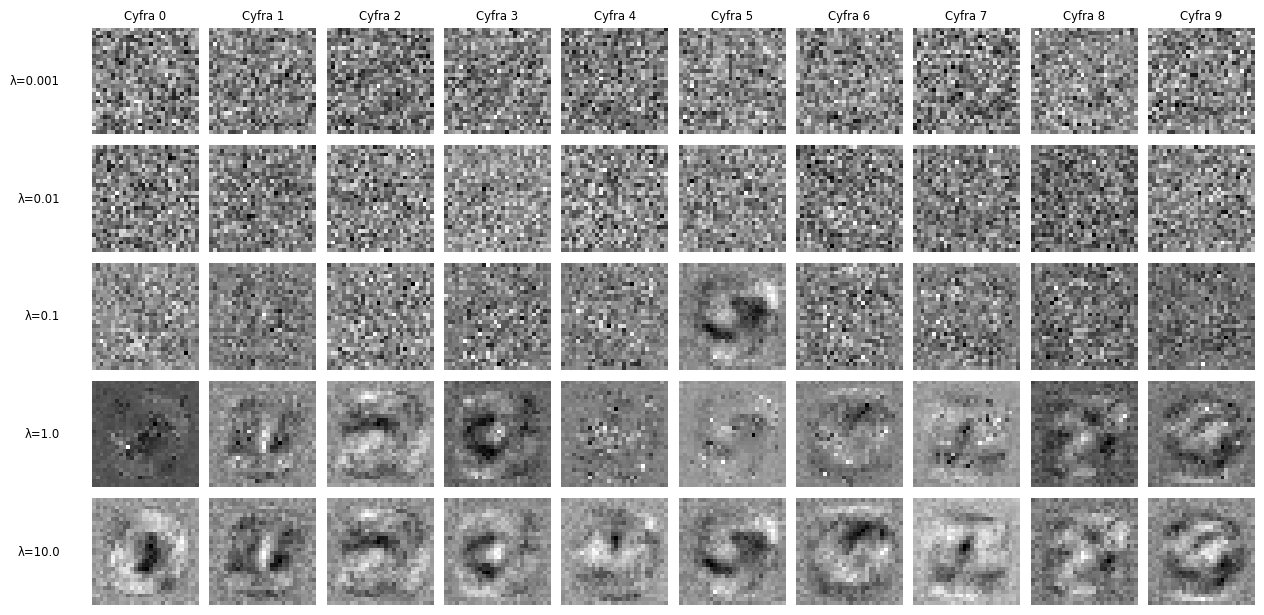

In [7]:
num_classes = 10
lambdas = [0.001, 0.01, 0.1, 1.0, 10.0]  # różne wartości regularyzacji L2
snapshots = {lam: [] for lam in lambdas}  # słownik do przechowywania snapshotów dla każdej λ
conf_history = {lam: [] for lam in lambdas} # struktura do przechowywania pewności klasyfikacji każdej klasy
target = torch.arange(num_classes, device=device)  # etykiety docelowe 0–9

# 1) Zbieranie pewności klasyfikacji oraz snapshotów co 50 kroków dla każdej wartości λ
for lam in lambdas:
    inp = torch.randn((num_classes, 1, 28, 28), device=device, requires_grad=True)  # losowy batch 10 obrazów
    opt = torch.optim.Adam([inp], lr=0.01)  # optymalizator
    for step in range(1000):
        opt.zero_grad()
        outs = net(inp)  # przejście przez sieć
        loss_ce = criterion(outs, target)  # strata klasyfikacyjna
        loss_l2 = lam * inp.pow(2).mean()  # kara L2 za wartości pikseli
        (loss_ce + loss_l2).backward()
        opt.step()

        probs = torch.softmax(outs, dim=1) # zbieranie pewności dla etykiet
        conf = probs[range(num_classes), range(num_classes)].detach().cpu().numpy()
        conf_history[lam].append(conf)
        if step % 50 == 0:
            snapshots[lam].append(inp.detach().cpu().clone())  # zapis snapshotu

# 2) Przygotowanie siatki wykresów (subplotów)
fig, axes = plt.subplots(len(lambdas), num_classes,
                         figsize=(num_classes*1.5, len(lambdas)*1.5),
                         gridspec_kw={'wspace':0.1, 'hspace':0.1})
for ax in axes.flatten():
    ax.axis('off')  # wyłączenie osi

# Dodanie tytułów kolumn (oznaczeń cyfr)
for j in range(num_classes):
    axes[0, j].set_title(f"Cyfra {j}", fontsize='small', pad=6)

# Dodanie opisu λ po lewej stronie każdego wiersza
for i, lam in enumerate(lambdas):
    axes[i, 0].text(-0.3, 0.5, f"λ={lam}", transform=axes[i,0].transAxes,
                    fontsize='small', va='center', ha='right')

# 3) Funkcja animująca - aktualizacja obrazów w każdej ramce
def animate(frame_idx):
    artists = []
    for i, lam in enumerate(lambdas):
        batch = snapshots[lam][frame_idx].squeeze(1).numpy()  # (10,28,28)
        for j in range(num_classes):
            img = batch[j]
            # normalizacja do [0,1]
            img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
            im = axes[i, j].imshow(
                img_norm,
                cmap='gray',  # skala szarości
                animated=True,
                vmin=0, vmax=1
            )
            artists.append(im)
    return artists

# 4) Utworzenie animacji
num_frames = len(snapshots[lambdas[0]])  # liczba klatek = liczba snapshotów
anim = animation.FuncAnimation(
    fig, animate, frames=num_frames, interval=300, blit=True
)

# 5) Wyświetlenie animacji w notebooku
HTML(anim.to_jshtml())

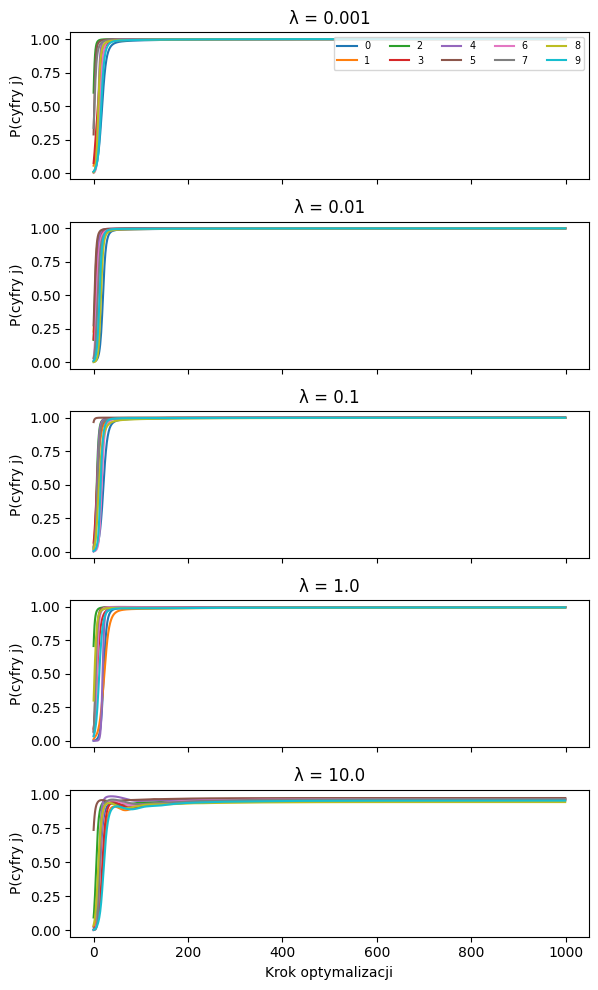

In [8]:
# Wykres pewności klasyfikacji każdej cyfry dla każdego λ
fig2, axes2 = plt.subplots(len(lambdas), 1, figsize=(6, len(lambdas)*2), sharex=True)

for i, lam in enumerate(lambdas):
    conf_arr = np.array(conf_history[lam])  # np.shape == (400,10)
    num_points = conf_arr.shape[0]
    steps = np.arange(num_points)           # [0,1,...,399]
    ax = axes2[i]
    for j in range(num_classes):
        ax.plot(steps, conf_arr[:, j], label=str(j))
    ax.set_ylabel("P(cyfry j)")
    ax.set_title(f"λ = {lam}")
    if i == 0:
        ax.legend(ncol=5, fontsize='x-small', loc='upper right')

axes2[-1].set_xlabel("Krok optymalizacji")
plt.tight_layout()
plt.show()

##KOMENTARZ DO ZADANIA 3 - CZĘŚĆ PIERWSZA


##**Czy sieć faktycznie „rozpoznaje” wygenerowane cyfry?**
We wszystkich przypadkach, od λ=0,001 aż po λ=10, sieć po optymalizacji przypisuje każdemu wyprodukowanemu obrazowi docelową etykietę z bardzo wysoką pewnością (softmax ≈1.0). Jednak dla bardzo dużego λ=10 możemy zauważyć, że sieć nie jest już tak bardzo pewna klasyfikacji etykiety jak w przypadku mniejszych λ.

##**Wpływ współczynnika L₂ na „jakość” wygenerowanych cyfr**

1. Bardzo mała kara (λ=0,001–0,01)\
Optymalizacja niemal całkowicie pomija ograniczenie wielkości pikseli i skupia się na maksymalizacji log-prawdopodobieństwa etykiety. Piksele przybierają skrajne, kontrastowe wartości, tworząc drobne, nieregularne wzory, które przez sieć są interpretowane jako cyfry z bardzo wysoką pewnością, ale dla oka pozostają chaosem.

2. Umiarkowana kara (λ=0,1–1,0)\
Kara L2 zaczyna tamować bezwzględne wahania pikseli. Aby utrzymać wysoką pewność, optymalizator „rzeźbi” bardziej globalne struktury – łuki, kreski i pętle – odpowiadające klasycznym konturom cyfr MNIST. W efekcie obrazy stają się bardziej gładkie, dla λ = 1.0 niektóre cyfry stają się na tyle wyraźne, że człowiek może je rozpoznać.

3. Silna kara (λ=10,0)\
Ogromne obciążenie L₂ powoduje, że piksele są tłumione i zbliżane do zera. Model wciąż może osiągnąć softmax ≈1.0, lecz robi to kosztem usunięcia większości detali. Powstają gładkie obrazy, miejscami mało kontrastowe. Jednak człowiek może rozpoznać więcej cyfr niż w przypadku λ = 1.0. Sieć natomiast nie jest już taka pewna klasyfikacji obrazu do danej cyfry jak w przypadku mniejszych wartości λ.

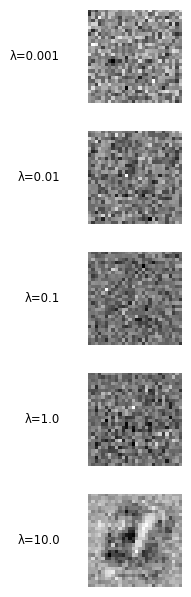

In [9]:
lambdas = [0.001, 0.01, 0.1, 1.0, 10.0]  # różne wartości współczynnika λ dla regularyzacji L2
pair_target = [1, 7]  # cyfry, do których obraz ma być podobny jednocześnie
num_steps = 600

# 1) Zbieranie pewności klasyfikacji oraz snapshotów dla każdej wartości lambda
snapshots = {}
confidences = {}
for lam in lambdas:
    inp = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)  # losowy obraz do optymalizacji
    opt = torch.optim.Adam([inp], lr=0.01)  # optymalizator
    this_snaps = []
    conf_1, conf_7 = [], []
    for step in range(num_steps):
        opt.zero_grad()
        # duplikacja wejścia: dwie kopie dla dwóch strat
        outs = net(inp.expand(2, -1, -1, -1))
        loss1 = criterion(outs[0:1], torch.tensor([1], device=device))  # strata dla cyfry 1
        loss2 = criterion(outs[1:2], torch.tensor([7], device=device))  # strata dla cyfry 7
        loss = loss1 + loss2 + lam * inp.pow(2).mean()  # suma dwóch strat + kara L2
        loss.backward()
        opt.step()

        # obliczamy softmax
        probs = torch.softmax(outs, dim=1)
        conf_1.append(probs[0, 1].item())  # pewność dla klasy "1" na pierwszym obrazie
        conf_7.append(probs[1, 7].item())  # pewność dla klasy "7" na drugim obrazie
        if step % 60 == 0:
            this_snaps.append(inp.detach().cpu().clone())  # zapis snapshotu
    snapshots[lam] = this_snaps  # przypisanie snapshotów dla danej λ
    confidences[lam] = {
        '1': conf_1,
        '7': conf_7
    }                            # zapisanie pewności klasyfikacji

# 2) Przygotowanie siatki wykresów: wiersze to wartości λ
fig, axes = plt.subplots(len(lambdas), 1,
                         figsize=(3, len(lambdas)*1.5),
                         gridspec_kw={'hspace':0.3})
for ax in axes.flatten():
    ax.axis('off')  # wyłączenie osi

# Dodanie etykiet λ po lewej stronie każdego wiersza
for i, lam in enumerate(lambdas):
    axes[i].text(-0.3, 0.5, f"λ={lam}", transform=axes[i].transAxes,
                 fontsize='small', va='center', ha='right')

# 3) Funkcja animująca: aktualizacja obrazów w kolejnych klatkach
num_frames = len(snapshots[lambdas[0]])  # liczba klatek = liczba snapshotów
def animate(frame_idx):
    artists = []
    for i, lam in enumerate(lambdas):
        img = snapshots[lam][frame_idx].squeeze().numpy()  # (28,28)
        img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)  # normalizacja pikseli
        im = axes[i].imshow(img_norm,
                            cmap='gray',  # skala szarości
                            animated=True,
                            vmin=0, vmax=1)
        artists.append(im)
    return artists

# 4) Utworzenie i wyświetlenie animacji
anim = animation.FuncAnimation(
    fig, animate, frames=num_frames, interval=150, blit=True
)
HTML(anim.to_jshtml())  # wyświetlenie animacji w notebooku


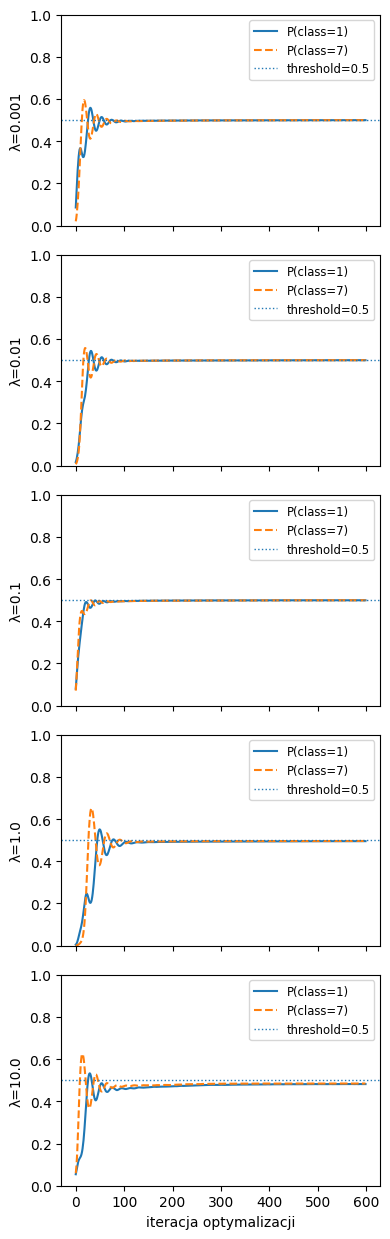

In [10]:
# Wykresy pewności dla każdej lambda
fig2, axes2 = plt.subplots(len(lambdas), 1, figsize=(4, len(lambdas)*2.5), sharex=True)
for i, lam in enumerate(lambdas):
    ax = axes2[i]
    steps = list(range(num_steps))
    ax.plot(steps, confidences[lam]['1'],     label='P(class=1)')
    ax.plot(steps, confidences[lam]['7'],     label='P(class=7)', linestyle='--')
    ax.axhline(0.5, linestyle=':', linewidth=1, label='threshold=0.5')
    ax.set_ylabel(f"λ={lam}")
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', fontsize='small')
ax.set_xlabel("iteracja optymalizacji")
plt.tight_layout()
plt.show()

##KOMENTARZ DO ZADANIA 3 - CZĘŚĆ DRUGA

##**Czy sieć faktycznie „rozpoznaje” wygenerowane cyfry?**

Sieć potrafi doprowadzić do wysokiej pewności dla obu klas jednocześnie (tak jak w zadaniu 2 sieć dąży do pewności klasyfikacji na poziomie 0.5 dla obu klas), ale w praktyce nie generuje czytelnych cyfr “1” czy “7”. Obrazy przypominają raczej zaszumione, rozmyte piksele, na które sieć ma silną odpowiedź, niż cyfry z oryginalnego zbioru MNIST.

##**Wpływ współczynnika L₂ na „jakość” wygenerowanych cyfr**

1. Małe λ (0.001 – 0.01)\
 -Kara jest zbyt słaba, więc optymalizacja “przeciąga” piksele w każdym kierunku, żeby osiągnąć wysoką pewność.\
 -Efekt: silny szum, ostre artefakty, nie da się dostrzec nawet zarysu cyfry.

2. Średnie λ (0.1 – 1.0)\
 -Kara zaczyna wyhamowywać narastanie ekstremalnych wartości pikseli.\
 -Obrazy stają się mniej zaszumione, jednak kształt cyfry wciąż jest bardzo zamazany i mało czytelny, da się dostrzec jedynie bardzo niewyraźne kontury pewnych struktur.

3. Duże λ (10.0)\
 -Kara L₂ znacząco tłumi zmienność wartości pikseli, przez co wygenerowane obrazy są nadmiernie wygładzone – choć zarys cyfry jest widoczny, całość sprawia wrażenie „zamglonej” z powodu niewielkiego zakresu amplitudy pikseli. \
 -Analogicznie jak w części pierwszej zadania 3 pewność modelu spada i utrzymuje się poniżej poziomu 0.5 w odróżnieniu od pozostałych wartości λ, dla których dla pewnej liczby iteracji pewność klasyfikacji utrzymuje się na stałym poziomie 0.5.